In [1]:
import pandas as pd
import numpy as np
from collections import Counter 
from PIL import Image
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
import random
from pycocoevalcap.cider.cider import Cider
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
pd.set_option('display.max_colwidth', None)

cuda


## Read Data.

In [ ]:
df = pd.read_csv(r".\flickr30k_images\results.csv", sep='|')
print(len(df))
display(df.head(3))

158915


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their hands while hanging out in the yard .
1,1000092795.jpg,1,"Two young , White males are outside near many bushes ."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .


## Preprocessing step -> Remove Single Character and non alpha Words. Add tokens. 

In [3]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [4]:
df['cleaned_caption'] = df[' comment'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in str(caption).split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [5]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

74


In [6]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

## Create vocab and map tokens to ID.

In [7]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [8]:
vocab_size = len(word_dict)
print(vocab_size)

17893


In [9]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}

In [10]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

## Train-Validation 80-20 split

In [11]:
df = df.sort_values(by = 'image_name')
train = df.iloc[:int(0.8*len(df))]
valid = df.iloc[int(0.8*len(df)):]

## Create DataLoader to load the data into Transformer Model.
## FlickerDataSetResnet will return 1 timestep left shifted caption sequence which model will predict and store image features from ResNet.

In [12]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image_name']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [13]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNetBest.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 16, shuffle=True)

In [14]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNetBest.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 16, shuffle=True)

### Position Embedding

In [15]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

## Transformer Decoder

In [16]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


## Lets Generate Captions !!!

In [17]:
model = torch.load('./BestModel1')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 74
print(start_token, end_token, pad_token)

C:\Users\sapat\AppData\Local\Temp\ipykernel_8400\3562904345.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./BestModel1')


1 2 0


In [18]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNetBest.pkl')

In [ ]:
def generate_caption(K, img_nm): 
    img_loc = './flickr30k_images/flickr30k_images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image_name']==img_nm]
    # print("Actual Caption : ")
    # print(valid_img_df[' comment'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)

    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index

            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    # print("\n")
    # print("Predicted caption : ")
    # print(" ".join(predicted_sentence+['.']))
    return valid_img_df[' comment'].tolist(), predicted_sentence

  0%|          | 0/1987 [00:00<?, ?it/s]

c:\Users\sapat\anaconda3\envs\image_ccap\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


0.32466791547509893
Average BLEU Score: 0.1641
CIDEr Score: 0.7422


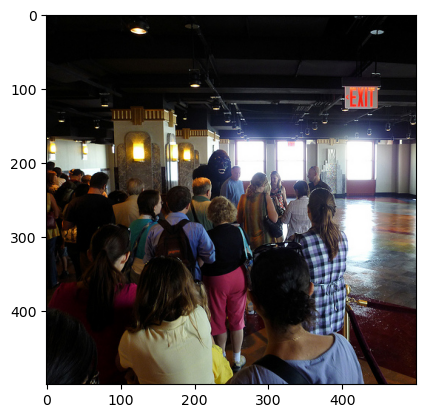

In [20]:
def evaluate_image_captioning_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    generated_captions = {}
    ground_truth_captions = {}
    
    # Generate captions for each batch in the validation set
    with torch.no_grad():
        for _, (caption_seq, target_seq, image_tensor_view) in tqdm(enumerate(dataloader), total=len(dataloader)):
            for i in range(len(image_tensor_view)):
                image_name = dataloader.dataset.data.iloc[i]['image_name']
                ground_truth_caption, predicted_caption = generate_caption(1, image_name)
                
                generated_captions[image_name] = [" ".join(predicted_caption)]
                ground_truth_captions[image_name] = ground_truth_caption
    
    # BLEU Score Calculation
    smoothing_function = SmoothingFunction().method1
    bleu_scores = []


    for image_id, generated_caption in generated_captions.items():
        # Make sure `references` is a list of lists of words
        references = [ref.split() for ref in ground_truth_captions[image_id]]  # Each reference split into words
        
        # Split the generated caption into words
        generated_caption_words = generated_caption[0].split()
        
        # Calculate BLEU score with smoothing
        score = sentence_bleu(references, generated_caption_words, smoothing_function=smoothing_function)
        bleu_scores.append(score)

    # Calculate the average BLEU score  
    print(np.max(bleu_scores))
    average_bleu_score = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU Score: {average_bleu_score:.4f}")
    
    # CIDEr Score Calculation
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(ground_truth_captions, generated_captions)
    print(f"CIDEr Score: {cider_score:.4f}")
    
    return {
        "BLEU": average_bleu_score,
        "CIDEr": cider_score
    }

# Usage
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# ground_truth_captions should be a dictionary with image IDs as keys and a list of true captions as values
evaluation_scores = evaluate_image_captioning_model(model, valid_dataloader_resnet)

### 1st Example 

In [21]:
unq_train_imgs = train[['image_name']].drop_duplicates()
unq_valid_imgs = valid[['image_name']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

25427 6357


([' Two men in black pants , black button-down shirts , and ties stand in front of an unmarked brown doorway .',
  ' Two men dressed in black pants and shirts are lounging outside a door .',
  ' Two men taking a break at the back of a business .',
  ' two men standing outside next to a building .',
  ' Two men taking a break during work .'],
 ['two',
  'men',
  'in',
  'business',
  'clothing',
  'stand',
  'outside',
  'of',
  'restaurant',
  'in',
  'front',
  'of',
  'the',
  'building',
  'with',
  'the',
  'buildings'])

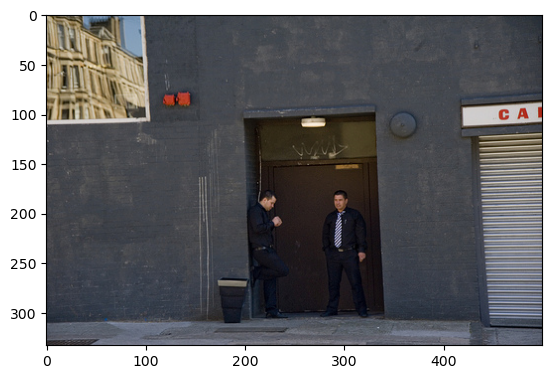

In [30]:
generate_caption(2, unq_valid_imgs.iloc[3]['image_name'])

([' A young adult is hula hooping .',
  ' A woman hula-hooping in a red shirt .',
  ' A young woman using a green hula hoop .',
  ' A young girl moves to a beat in a midriff baring shirt and jeans .',
  ' A woman in jeans and a revealing top is jumping in front of a green hoop-like structure .'],
 ['young',
  'girl',
  'in',
  'pink',
  'shirt',
  'and',
  'jeans',
  'is',
  'walking',
  'down',
  'green',
  'tunnel'])

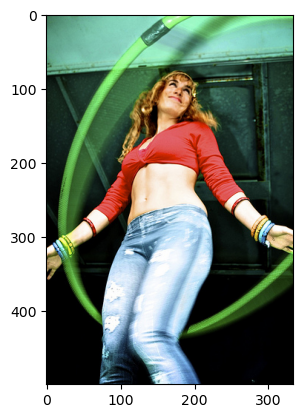

In [34]:
generate_caption(1, unq_valid_imgs.iloc[55]['image_name'])